In [1]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from farich_functions import *

plt.rcParams['font.size'] = 12

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# xgb.__version__

In [4]:
# momentum_from_beta(beta_from_momentum(500, pi_mass), ka_mass)

In [162]:
filepath = os.path.join("data", "decay_test_ka2.root")
filepath = os.path.join("data", "decay_test_2gamma.root")
filepath = os.path.join("data", "decay_test_KmuKpi.root")

In [163]:
file = uproot.open(filepath)

In [164]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [165]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) # 40% К куда-то пропадают в фариче

In [121]:
primary_pdgid[3]

array([    30443,       421,      -321,       211,       111,        22,
              22,      -421, 480000000])

In [10]:
pis = mus = 0
for i in range(len(primary_pdgid)):
    if primary_pdgid[i][3] != 211 and primary_pdgid[i][3] != -13:
        print('First not gamma')
    if primary_pdgid[i][3] == 211:
        pis += 1
    if primary_pdgid[i][3] == -13:
        mus += 1
print(pis, mus, pis/mus, 0.013580300000000002/0.034700000)
    # if primary_pdgid[i][6] != 22:
    #     print('Second not gamma')

2718 7282 0.3732491073880802 0.3913631123919309


In [11]:
file[file.keys()[0]]['allGenParticles'].keys()

[b'allGenParticles.core.pdgId',
 b'allGenParticles.core.charge',
 b'allGenParticles.core.status',
 b'allGenParticles.core.vertex.x',
 b'allGenParticles.core.vertex.y',
 b'allGenParticles.core.vertex.z',
 b'allGenParticles.core.p4.mass',
 b'allGenParticles.core.p4.px',
 b'allGenParticles.core.p4.py',
 b'allGenParticles.core.p4.pz',
 b'allGenParticles.core.bits']

In [153]:
psi_px = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
psi_py = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
psi_pz = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
psi_p = np.sqrt(psi_px**2+psi_py**2+psi_pz**2)

pi0_px = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
pi0_py = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
pi0_pz = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
pi0_p = np.sqrt(pi0_px**2+pi0_py**2+pi0_pz**2)

gamma1_px = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
gamma1_py = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
gamma1_pz = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
gamma1_p = np.sqrt(gamma1_px**2+gamma1_py**2+gamma1_pz**2)


gamma2_px = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
gamma2_py = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
gamma2_pz = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
gamma2_p = np.sqrt(gamma2_px**2+gamma2_py**2+gamma2_pz**2)

In [146]:
np.sum(gamma1_p  * 1000 < 30)

386

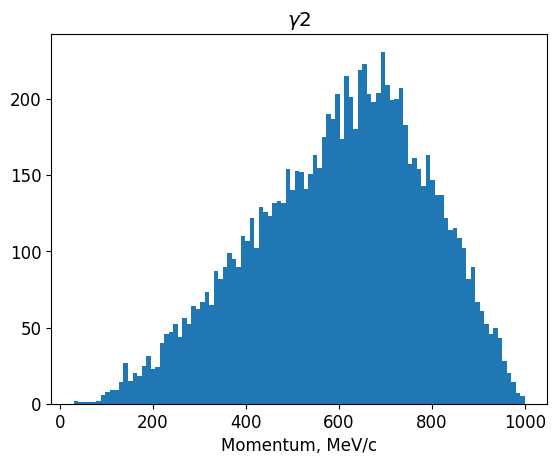

In [154]:
plt.hist(psi_p*1000, bins=100)
plt.title(r'$\gamma$2')
plt.xlabel('Momentum, MeV/c')
plt.show()

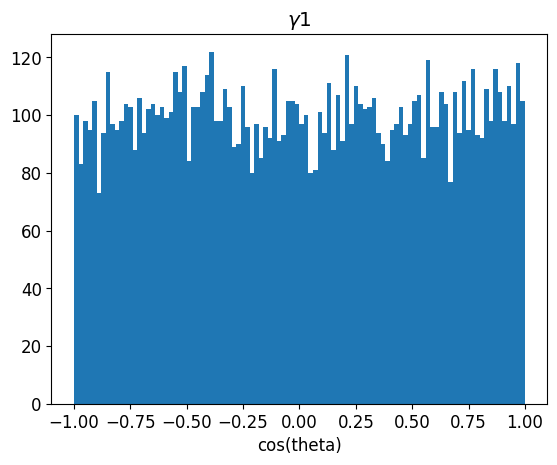

In [144]:
plt.hist(gamma1_pz / gamma1_p, bins=100)
plt.title(r'$\gamma$1')
plt.xlabel('cos(theta)')
plt.show()

In [130]:
m_pi = 135.0

# входной массив импульсов пиона (в МэВ/c)
p_pion_lab = pi0_p * 1000  # сюда подставь свой массив

# Энергия пиона
E_pion_lab = np.sqrt(p_pion_lab**2 + m_pi**2)

# beta и gamma
beta = p_pion_lab / E_pion_lab
gamma = E_pion_lab / m_pi

# Сэмплируем cos(theta*) из равномерного распределения [-1, 1]
cos_theta_star = np.random.uniform(-1, 1, size=len(p_pion_lab))

# Энергии (и импульсы) фотонов
E_gamma_1 = 0.5 * m_pi * gamma * (1 + beta * cos_theta_star)
E_gamma_2 = 0.5 * m_pi * gamma * (1 - beta * cos_theta_star)

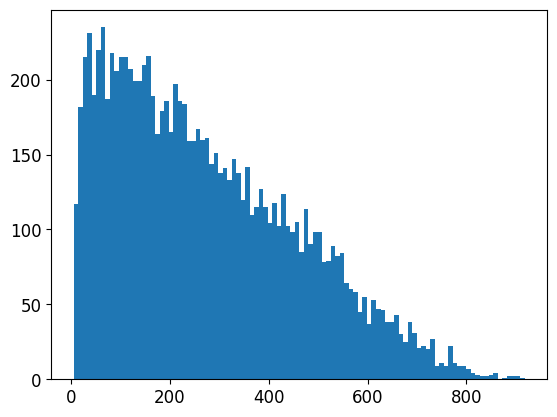

In [131]:
plt.hist(E_gamma_1, bins=100)
plt.show()

In [40]:
cos_theta_lim = 1280 / np.sqrt(1280 ** 2 + 210 ** 2)

good_gamma_ind = []
for i in range(len(gamma1_p)):
    if gamma1_p[i] < 30 / 1000:
        continue
    if gamma2_p[i] < 30 / 1000:
        continue
    if np.abs(gamma1_pz[i] / gamma1_p[i]) > cos_theta_lim:
        continue
    if np.abs(gamma2_pz[i] / gamma2_p[i]) > cos_theta_lim:
        continue
    good_gamma_ind.append(i)

In [77]:
(10000 - len(good_gamma_ind)) / 100

9.77

In [75]:
0.139000000 * (10000 - len(good_gamma_ind)) / 10000

0.013580300000000002

In [12]:
def primary_particle_match_test(primary_particles_array, ids_to_check, ids_to_match, verbose=False):
    for i in range(len(ids_to_check)):
        if primary_particles_array[ids_to_check[i]] != ids_to_match[i]:
            if verbose:
                print(f'Expected {ids_to_match[i]} but got {primary_particles_array[ids_to_check[i]]} in {ids_to_check[i]}-th position')
            return False    
    return True

In [13]:
def find_primary_in_farich(primary_particles_array, farich_particles_array, primary_id, pdg_id, verbose=False):
    find_index_of_pdg_id = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == pdg_id)).size and (idx[-1] < arr.size) else False)
    if primary_particles_array[primary_id] == pdg_id:
        if find_index_of_pdg_id(farich_particles_array) is not False:
            if primary_particles_array[primary_id] != farich_particles_array[find_index_ka(farich_pdgid[i])]:
                if verbose:
                    print('Mismatch', i)
                mismatches.append(i)
                is_good = False
        else:
            if verbose:
                print('No ka in event', i)
            is_good = False
            no_ka.append(i)
    if is_good:
        good_events.append(i)
        primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
        primary_particle_in_primary_idx.append(2)

In [14]:
i = 0
empty_farich = 0
important_particle_ind = 3
mismatches = []
good_events = []
good_mu_events = []
good_ka_events = []
primary_particle_idx = []
primary_particle_in_primary_idx = []
no_mu_in_mu = []
no_pi_in_pi = []
no_ka = []
# find_index = lambda arr: (idx[-1]+1 if (idx := np.flatnonzero(arr == -22)).size and (idx[-1]+1 < arr.size) else 0) # моржовый оператор :)
find_index = lambda arr: (idx[-1] + 1 if (idx := np.flatnonzero(np.isin(arr, [-22, -11]))).size and (idx[-1] + 1 < arr.size) else 0)
find_index_mu = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -13)).size and (idx[-1] < arr.size) else False)
find_index_pi = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == 211)).size and (idx[-1] < arr.size) else False)
find_index_ka = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -321)).size and (idx[-1] < arr.size) else False)

# need 2 rings per event now...

for primary_particles in primary_pdgid:
    is_good = True
                
    if farich_pdgid[i].shape[0] == 0 or np.flatnonzero(farich_pdgid[i] + 22).shape[0] == 0:
        empty_farich += 1
        is_good = False
        
    if is_good:
        is_good = primary_particle_match_test(primary_particles, [0, 1, 2], [30443, 421, -321], True)

    if primary_particles[2] == -321 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_ka(farich_pdgid[i]) is not False:
                if primary_particles[2] != farich_pdgid[i][find_index_ka(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No ka in event', i)
                is_good = False
                no_ka.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(2)
            
            
    if primary_particles[important_particle_ind] == -13 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_mu(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No mu in mu event', i)
                is_good = False
                no_mu_in_mu.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_mu(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()
    
    elif primary_particles[important_particle_ind] == 211 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_pi(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No mu in mu event', i)
                is_good = False
                no_pi_in_pi.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_pi(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()

    # if is_good:
    #     good_events.append(i)
    #     primary_particle_idx.append(find_index(farich_pdgid[i]))
    i += 1
    

print('Empty Farich:',empty_farich)
print('Mismatches: ',len(mismatches))
print('Missing K: ',len(no_ka))
print('Missing Mu in Mu event: ',len(no_mu_in_mu))
print('Missing Pi in Pi event: ',len(no_pi_in_pi))
print('Full bad events: ', len(mismatches) + empty_farich + len(set(np.concatenate([no_mu_in_mu, no_ka, no_pi_in_pi]))))
print('Good Events:', i - len(mismatches) - empty_farich - len(set(np.concatenate([no_mu_in_mu, no_ka, no_pi_in_pi]))))
print(len(good_events))
print(len(set(good_events)))
print(- len(set(good_events)) + len(good_events))

Empty Farich: 738
Mismatches:  0
Missing K:  3356
Missing Mu in Mu event:  784
Missing Pi in Pi event:  343
Full bad events:  5221
Good Events: 4779
9558
4779
4779


In [15]:
farich_energy = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.energy'].array())[good_events]
farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]

primary_momentum_x = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
primary_momentum_y = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
primary_momentum_z = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]

farich_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
farich_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
farich_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
farich_t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]

In [158]:
primary_momentum = primary_momentum_x.copy()
for i in range(len(primary_momentum_x)):
    primary_momentum[i] = np.sqrt(primary_momentum_x[i] ** 2 + primary_momentum_y[i] ** 2 + primary_momentum_z[i] ** 2)

In [168]:
primary_pdgid[good_events[2]]

array([    30443,       421,      -321,       -13,        14,      -421,
       480000000])

In [169]:
cos_mu = []
cos_pi = []
cos_ka_mu = []
cos_ka_pi = []
for i in range(len(set(good_events))):
    if primary_pdgid[good_events[i]][3] == -13:
        cos_mu.append(primary_momentum_z[i][3] / primary_momentum[i][3])
        cos_ka_mu.append(primary_momentum_z[i][2] / primary_momentum[i][2])
    elif primary_pdgid[good_events[i]][3] == 211:
        cos_pi.append(primary_momentum_z[i][3] / primary_momentum[i][3])
        cos_ka_pi.append(primary_momentum_z[i][2] / primary_momentum[i][2])
# primary_momentum[0]

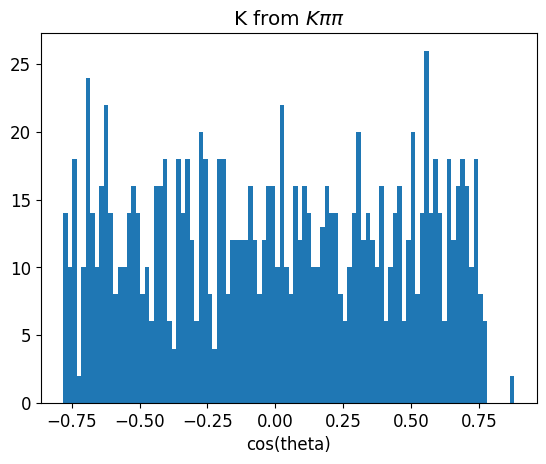

In [177]:
plt.hist(cos_ka_pi, bins=100)
plt.xlabel('cos(theta)')
plt.title(r'K from $K\pi\pi$')
plt.show()

In [179]:
np.sum([primary_pdgid[good_events[i]][3] == 211 for i in range(len(good_events))]) 

2422

In [178]:
np.sum([primary_pdgid[good_events[i]][3] == 211 for i in range(len(good_events))]) / np.sum([primary_pdgid[good_events[i]][3] == -13 for i in range(len(good_events))]) # pi / mu

0.3394058295964126

In [17]:
np.sum([primary_pdgid[good_events[i]][primary_particle_in_primary_idx[i]] == -321 for i in range(0, len(good_events), 2)]) # every even is k

4779

In [18]:
np.sum([primary_pdgid[i][2] == -321 for i in range(10000)]) 

10000

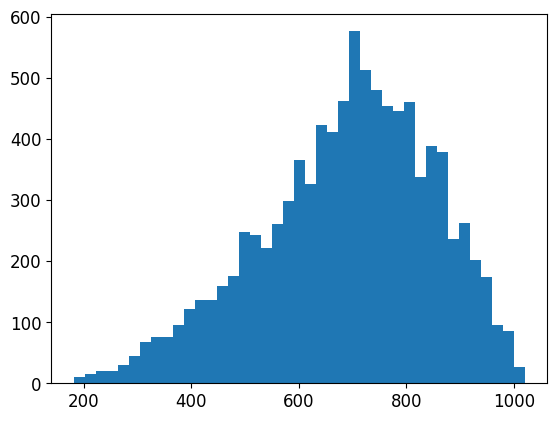

In [19]:
plt.hist([np.sqrt((primary_momentum_x[i][2]) ** 2 + (primary_momentum_y[i][2]) ** 2 + (primary_momentum_z[i][2]) ** 2) * 1000 for i in range(len(good_events))], bins='auto')
plt.show()

In [20]:
def init_coords_decay(file, grid):
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
        
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    y3 = np.array([y3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    z3 = np.array([z3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    # Объединяем массивы, сохраняя структуру массивов
    true_direction_coordinates = np.stack((x3, y3, z3), axis=1)
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id


In [21]:
datadir = "data"
sipm_eff, PDE_wvs = init_sipm_eff()
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

x_grid = np.arange(
    -3 * norm_r * np.sin(np.pi / 27),
    3 * norm_r * np.sin(np.pi / 27),
    SIPM_CELL_SIZE,
)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

decay_file = uproot.open(filepath)
coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
    decay_file, grid
)


In [22]:
intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

array([[-1.7381977e-01, -7.3313612e-01, -3.4249816e-02],
       [ 2.5178266e-01, -4.2465944e-02,  1.2554459e-01],
       [-3.7547314e-01, -4.8471576e-01, -5.9202647e-01],
       ...,
       [ 1.6258612e-01, -5.5150247e-01,  7.9757892e-02],
       [ 7.2456128e-04,  4.1843048e-01, -3.6699966e-01],
       [-3.2155937e-01,  2.1855320e-01,  4.8274177e-01]], dtype=float32)

In [23]:
def find_cylinder_intersections(vectors, R=1000):
    # vectors - массив размерности (N, 3)
    # R - радиус цилиндра
    
    # Вычисляем t для каждого вектора
    a_x = vectors[:, 0]
    a_y = vectors[:, 1]
    denominator = np.sqrt(a_x**2 + a_y**2)
    
    # Избегаем деления на ноль (векторы, параллельные оси z)
    mask = denominator != 0
    t = np.zeros_like(denominator)
    t[mask] = R / denominator[mask]
    
    # Вычисляем координаты пересечения
    intersections = vectors * t[:, np.newaxis]
    
    return intersections


In [24]:
intersection_diffs = np.sqrt(np.sum((find_cylinder_intersections(intersections, R=1000) - intersections) ** 2, axis=1))

In [25]:
intersection_diffs[intersection_diffs > 100].shape 

(0,)

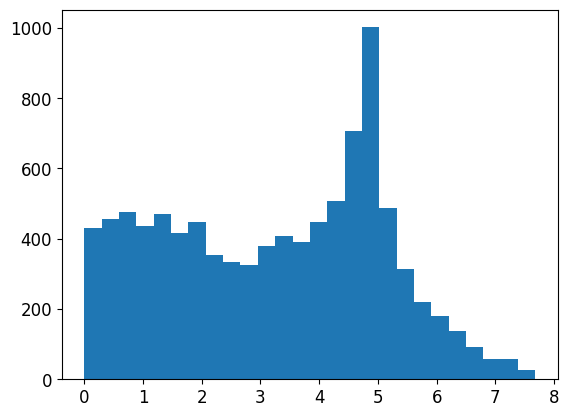

In [26]:
plt.hist(intersection_diffs[intersection_diffs < 100], bins='auto') # Короче, просто используем intersections, координаты важнее
plt.show() 

In [27]:
def find_intersections_for_decay(full_coords):
    intersections = np.zeros((full_coords.shape[0], 3))
    zeros = np.zeros((1, 3))
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i] / 1000
        pca = PCA(n_components=1)

        # if event_coords[0].shape[0] == 1:
        # print(event_coords)
        event_coords = [[0, arr] for arr in event_coords]
        # print(event_coords)
        pca.fit(np.column_stack(event_coords))
        line_direction = pca.components_[0]
        line_point = pca.mean_

        # Calculate the parameter t for the intersection with the plane y=1000
        p_y = line_point[1]
        d_y = line_direction[1]
        t = (1000 - p_y) / d_y

        # Find the intersection point
        intersection_point = line_point + t * line_direction

        # print(f"Line direction: {line_direction}")
        # print(f"Point on the line: {line_point}")
        # print(f"Intersection point with the plane y=1000: {intersection_point}")
        for j in range(3):
            intersections[i][j] = intersection_point[j]
    return intersections


In [28]:
def rotate_lines_for_decay(full_coords):
    angles = np.zeros(full_coords.shape[0])
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i]
        rotated_event_coords, angles[i] = rotate_line_for_decay(event_coords)

        for j in range(3):
            full_coords[i][j] = rotated_event_coords[:, j]
    return angles


def rotate_line_for_decay(coords):
    angles = np.arctan2(coords[1], coords[0]) % (2 * np.pi)
    # print(angles)
    try:
        median_angle = angles
    except IndexError:
        print(angles)
        median_angle = np.median(angles)
    median_angle = lin_move_to_grid(np.array([median_angle]), plane_angles)
    # print(angles)
    angle_to_rotate = np.pi / 2 - median_angle
    # print(angle_to_rotate)
    x, y = rotate_point_on_line(coords, angle_to_rotate)
    return np.column_stack((x, y, coords[2])), median_angle


In [29]:
def create_edf_decay(
    filepath="fullsim_optical_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root",
    uncertain_angle=False,
):
    datadir = "data"
    sipm_eff, PDE_wvs = init_sipm_eff()
    for key in sipm_eff.keys():
        sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

    x_grid = np.arange(
        -3 * norm_r * np.sin(np.pi / 27),
        3 * norm_r * np.sin(np.pi / 27),
        SIPM_CELL_SIZE,
    )
    z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
    grid = (x_grid, z_grid, PDE_wvs)

    decay_file = uproot.open(os.path.join(datadir, filepath))
    coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
        decay_file, grid
    )
    
    
    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)

    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    true_direction_coordinates = intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

    if uncertain_angle:
        uncertainty_introduction_to_direction(true_direction_coordinates)
    
    sipm_sim(coordinates, sipm_eff)
    for i, coord in enumerate(coordinates):
        # print(coord[0].shape)
        # print(coord)
        # if coord[0].shape[0] != 0:
        #     break
        if coord[0].shape[0] == 0:
            coord[0] = np.atleast_1d(np.array(intersections[i][0]))
            coord[1] = np.atleast_1d(np.array(intersections[i][1]))
            coord[2] = np.atleast_1d(np.array(intersections[i][2]))
            coord[3] = np.atleast_1d(np.array(450))
            coord[4] = np.atleast_1d(np.array(0.633))
    # idx_to_drop = []
    # for i in range(coordinates.shape[0]):
    #     if coordinates[i][0].shape[0] == 0:
    #         idx_to_drop.append(i)
    # coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    # true_direction_coordinates = np.delete(
    #     true_direction_coordinates, idx_to_drop, axis=0
    # )
    # intersections = np.delete(intersections, idx_to_drop, axis=0)
    # ids = np.delete(ids, idx_to_drop)
    # print(coordinates.shape)
    # print(true_direction_coordinates.shape)

    main_angles = rotate_lines_for_decay(intersections) # Rotates intersection points
    
    intersections = find_intersections_for_decay(intersections)  # May need to rewrite both to treat elements as scalasrs and to change reference point from 0
    
    rotate_events(coordinates, main_angles)   # There are events with extra rings somewhere around angle idx 13-16
    move_events_to_grid(coordinates, grid)
    repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])
    edf = pd.DataFrame(coordinates, columns=["x_c", "y_c", "z_c", "wv_c", "t_c"])

    unraveled_data = {col: [] for col in edf.columns}
    row_indices = []

    # Iterate over the DataFrame and unravel the arrays
    for i, row in edf.iterrows():
        max_length = max(len(row[col]) for col in edf.columns)
        for k in range(max_length):
            row_indices.append((i, k))
            for col in edf.columns:
                if k < len(row[col]):
                    unraveled_data[col].append(row[col][k])
                else:
                    unraveled_data[col].append(
                        np.nan
                    )  # Handle cases where arrays are of different lengths

    # Create a new DataFrame from the unraveled data
    unraveled_df = pd.DataFrame(unraveled_data)

    # Create a MultiIndex for the rows
    multi_index = pd.MultiIndex.from_tuples(row_indices, names=["entry", "subentry"])
    unraveled_df.index = multi_index

    edf = unraveled_df

    edf["x_i"] = np.repeat(intersections[:, 0], repeat_nums, axis=0)
    edf["z_i"] = np.repeat(intersections[:, 2], repeat_nums, axis=0)

    x = y = z = x3 = y3 = z3 = unraveled_data = row_indices   = wvs = coordinates = file = coordinates_low = file_low = 0 # = main_angles

    bdf = pd.DataFrame()
    gdf = pd.DataFrame()
    gdf["nhits"] = repeat_nums

    mu_mass = 105.65
    pi_mass = 139.57
    ka_mass = 493.68
    # mass = mu_mass if is_mu else (ka_mass if is_ka else pi_mass)
    mass = np.array([mu_mass if ids[i] == -13 else (ka_mass if ids[i] == -321 else pi_mass) for i in range(ids.shape[0])])
    # edf.drop("y_c", axis=1, inplace=True)
    edf.rename(columns={"y_c": "tmp_c"}, inplace=True)
    edf.drop("wv_c", axis=1, inplace=True)
    edf.rename(columns={"z_c": "y_c", "z_i": "y_i"}, inplace=True)
    edf.rename(columns={"tmp_c": "z_c"}, inplace=True)
    # edf["z_c"] = np.zeros(edf.shape[0]) + 1000  
    # edf["mass"] = np.ones(edf.shape[0]) * mass
    edf["mass"] = np.repeat(
        mass,
        repeat_nums,
        axis=0,
    )
    edf["true_p"] = np.repeat(
        np.linalg.norm(true_direction_coordinates.astype("float"), axis=1) * 1000,
        repeat_nums,
        axis=0,
    )
    edf["beta"] = edf.true_p / np.sqrt(edf.mass**2 + edf.true_p**2)
    edf["x_p"] = np.zeros(edf.shape[0])
    edf["y_p"] = np.zeros(edf.shape[0])
    edf["z_p"] = np.zeros(edf.shape[0])
    edf["nx_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 0],
        repeat_nums,
        axis=0,
    )
    edf["ny_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 2],
        repeat_nums,
        axis=0,
    )
    edf["nz_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 1],
        repeat_nums,
        axis=0,
    )

    true_direction_coordinates = repeat_nums = true_direction_coordinates_low = mass = intersections = 0
    return edf, bdf, gdf, main_angles


In [30]:
def enforce_float32(df):
    return df.astype({col: np.float32 for col in df.select_dtypes(include=['float64']).columns})

In [31]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.]  # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [32]:
mu_pi_ka = True
if mu_pi_ka:
    edf_mu, bdf_mu, gdf_mu = create_edf('fullsim_3particles_2000_mu_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=11,
                               uncertain_angle=False, is_mu=True, is_ka=False)
    edf_pi, bdf_pi, gdf_pi = create_edf('fullsim_3particles_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                               uncertain_angle=False, is_mu=False, is_ka=False)
    edf_ka, bdf_ka, gdf_ka = create_edf('fullsim_3particles_2000_ka_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                                    uncertain_angle=False, is_mu=False, is_ka=True)
    
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)

(22000, 5)
(22000, 3)
(21094, 5)
(21094, 3)
(19993, 5)
(19993, 3)
(19879, 5)
(19879, 3)
(19986, 5)
(19986, 3)
(19861, 5)
(19861, 3)


In [33]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []


r_bins = np.arange(16, 80, step=3.3)
r_bins = np.array([[r_bins[i], r_bins[i + 2]] for i in range(len(r_bins) - 2)])
t_bins = np.arange(0, 7, step=0.25)
t_bins = np.array([[t_bins[i], t_bins[i + 1]] for i in range(len(t_bins) - 1)])

background_means_dict = {'1e6': 0.012, '1e5': 0.0015}
background_stds_dict = {'1e6': 0.0175, '1e5': 0.0055}

background_mean = background_means_dict['1e5']
background_std = background_stds_dict['1e5']

batch_size = 10000
num_of_classes = 4

In [34]:
dcr = '0'
print(dcr)
timer_start = perf_counter()
edf_d = edf_conc.copy()
gdf_d = gdf_conc.copy()
bdf_d = pd.DataFrame()
edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
edf_d = applySpaceCut(edf_d)
planeRecalculation(edf_d, idf)
planeRotation(edf_d)
edf_d = applySecondSpaceCut(edf_d)
edf_to_bdf(edf_d.mass, bdf_d)
edf_to_bdf(edf_d.true_p, bdf_d)
bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf_d.beta, bdf_d)
recoAngles(edf_d, idf)
primaryDirectionRecalculation(edf_d)

recoAngles(edf_d, idf, rotation_mode=True)

calculateSignalCounts(edf_d, bdf_d)

cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                           step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                           calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                           target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
    
print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))

0
    Generate noise with DCR per mm^2 0.0, mean number of hits per event: 0.00.
Time elapsed on current DCR:  64


In [35]:
bdf_d = pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5.pkl'))

In [31]:
Ы

NameError: name 'Ы' is not defined

In [36]:
bdf_d['mass'].fillna(0, inplace=True)

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

In [38]:
# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X = bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y = bdf_d['mass']

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # mass: [139.57 -> 0, 105.65 -> 1]
# 
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [33]:
# Step 4: Initialize and train XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    multi_class='ovr',
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42,
    nthread=-1,
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.9300624589086127
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      3018
           1       0.91      0.93      0.92      3201
           2       0.91      0.87      0.89      2976
           3       0.99      0.95      0.97      2973

    accuracy                           0.93     12168
   macro avg       0.93      0.93      0.93     12168
weighted avg       0.93      0.93      0.93     12168



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
def modelfit(alg, dtrain, target, use_train_cv=True, cv_folds=5, early_stopping_rounds=50):
    
    if use_train_cv:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=target)
        cv_result = xgb.cv(
            xgb_param, xgtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            as_pandas=True
        )
        alg.set_params(n_estimators=cv_result.shape[0])
    
    # Обучение модели
    alg.fit(dtrain, target)
    
    # Прогнозирование на обучающем наборе
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)
    
    # Вывод отчета о модели
    print("\nModel Report")
    print(f"Estimated number of estimators: {alg.get_params()['n_estimators']}")
    print(f"Accuracy : {accuracy_score(target, dtrain_predictions):.4g}")
    print(f"AUC Score (Train): {roc_auc_score(target, dtrain_predprob, multi_class='ovr'):.6f}")
    print("Classification Report:\n", classification_report(target, dtrain_predictions))
    # Важность признаков
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()



Model Report
Estimated number of estimators: 225
Accuracy : 0.9564
AUC Score (Train): 0.997255
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.95     12266
           1       0.95      0.96      0.96     12673
           2       0.96      0.92      0.94     11949
           3       0.99      0.96      0.98     11783

    accuracy                           0.96     48671
   macro avg       0.96      0.96      0.96     48671
weighted avg       0.96      0.96      0.96     48671



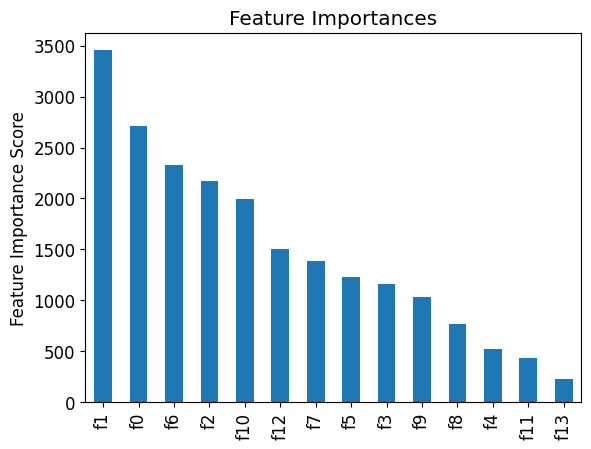

In [37]:

modelfit(model, X_train, y_train)

In [159]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(1, 10),
 'min_child_weight':range(1, 10)
}
gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=407,  # Подобрали выше
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test1,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)


{'max_depth': 5, 'min_child_weight': 1} 0.9965279639934014


In [166]:
param_test2 = {
 'gamma': np.linspace(0.5, .7, num=11),
}
gsearch2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=407,   # Подобрали выше
        max_depth=5,        # Подобрали выше
        min_child_weight=1, # Подобрали выше
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test2,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'gamma': 0.6} 0.9965919144515845


In [170]:
modelfit(xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,   # Подбираем снова
        max_depth=5,         # Подобрали выше
        min_child_weight=1,  # Подобрали выше
        gamma=0.6,           # Подобрали выше
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ), X_train, y_train)


Model Report
Estimated number of estimators: 650
Accuracy : 0.9786
AUC Score (Train): 0.999271
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12289
           1       0.97      0.98      0.97     12570
           2       0.97      0.96      0.97     11918
           3       1.00      0.98      0.99     11887

    accuracy                           0.98     48664
   macro avg       0.98      0.98      0.98     48664
weighted avg       0.98      0.98      0.98     48664



In [172]:
param_test3 = {
  'subsample':[i/100.0 for i in [85, 90, 95]],
  'colsample_bytree':[i/100.0 for i in [75, 80, 85]],
}
gsearch3 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=650,   # Подобрали выше
        max_depth=5,        # Подобрали выше
        min_child_weight=1, # Подобрали выше
        gamma=0.6,          # Подобрали выше
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test3,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'colsample_bytree': 0.75, 'subsample': 0.9} 0.9966405653227426


In [174]:
param_test4 = {
  'reg_alpha':[0.5 * 1e-5, 1e-5, 0.5 * 1e-6, 1e-6, 1e-4]
}
gsearch4 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=650,     # Подобрали выше
        max_depth=5,          # Подобрали выше
        min_child_weight=1,   # Подобрали выше
        gamma=0.6,            # Подобрали выше
        subsample=0.9,        # Подобрали выше
        colsample_bytree=0.75, # Подобрали выше
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test4,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

{'reg_alpha': 1e-05} 0.9966583745976845


In [177]:
modelfit(xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.01,     # Уменьшили
        n_estimators=10000,      # Подбираем снова
        max_depth=5,           # Подобрали выше
        min_child_weight=1,    # Подобрали выше
        gamma=0.6,             # Подобрали выше
        subsample=0.9,         # Подобрали выше
        colsample_bytree=0.75, # Подобрали выше
        reg_alpha=1e-5,        # Подобрали выше
        seed=42,
        n_jobs=-1  
    ), X_train, y_train)


Model Report
Estimated number of estimators: 6884
Accuracy : 0.9773
AUC Score (Train): 0.999131
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12289
           1       0.97      0.98      0.97     12570
           2       0.97      0.96      0.97     11918
           3       1.00      0.98      0.99     11887

    accuracy                           0.98     48664
   macro avg       0.98      0.98      0.98     48664
weighted avg       0.98      0.98      0.98     48664



In [39]:
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False,
    learning_rate=0.1,     
    n_estimators=650,      # Подбираем снова
    max_depth=5,           # Подобрали выше
    min_child_weight=1,    # Подобрали выше
    gamma=0.6,             # Подобрали выше
    subsample=0.9,         # Подобрали выше
    colsample_bytree=0.75, # Подобрали выше
    reg_alpha=1e-5,        # Подобрали выше
    seed=42,
    n_jobs=-1  
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.9596416241985862
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2993
           1       0.95      0.94      0.94      3282
           2       0.93      0.93      0.93      2968
           3       1.00      0.97      0.99      2923

    accuracy                           0.96     12166
   macro avg       0.96      0.96      0.96     12166
weighted avg       0.96      0.96      0.96     12166



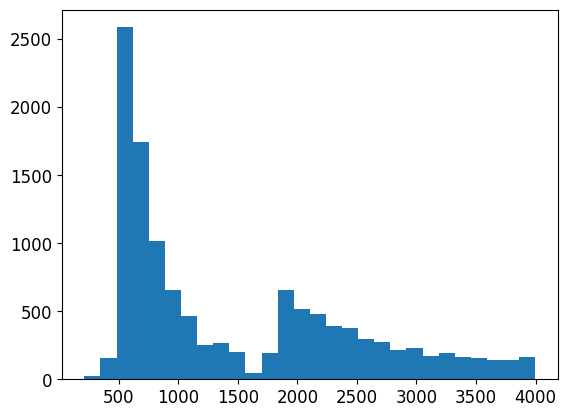

In [38]:
plt.hist(X_test.momentum, bins='auto')
plt.show()

In [43]:
X_test

,momentum,unfixed_calculated_r_2d_4_rsigms_4_tsigms,theta_p,distance,mass,mass_reco
24221,543.753723,28.182239,0.174442,24.754599,139.570007,139.570007
38845,2844.643311,60.032837,0.719279,23.200367,493.679993,493.679993
8854,3011.468018,19.164121,0.440068,5.235825,0.000000,0.000000
40472,2073.844971,33.532218,0.091515,31.237670,493.679993,493.679993
8489,809.658936,67.438866,0.782710,16.750386,105.650002,105.650002
...,...,...,...,...,...,...
55292,1963.284546,29.271972,0.251942,30.962637,493.679993,493.679993
20788,573.239380,22.038079,0.776762,5.235825,0.000000,0.000000
26772,606.456787,44.370106,0.269527,31.824445,105.650002,105.650002
14277,1893.974121,28.668418,0.099613,20.840705,493.679993,493.679993


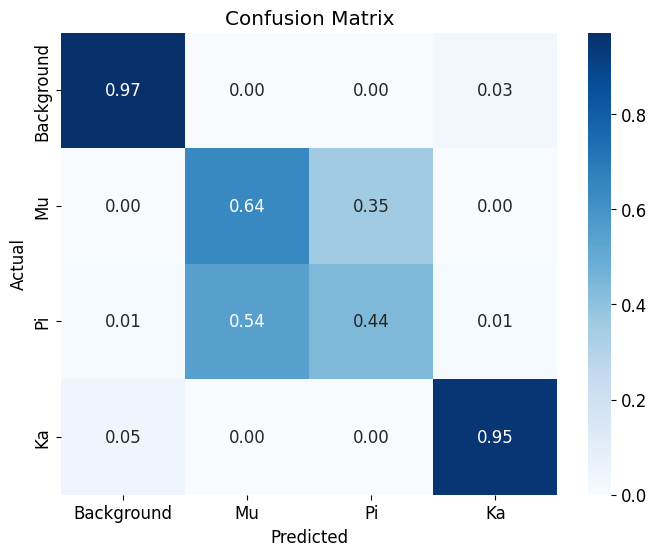

In [39]:
cm = confusion_matrix(label_encoder.transform(X_test[X_test.momentum > 1500].mass), model.predict(X_test[X_test.momentum > 1500][['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

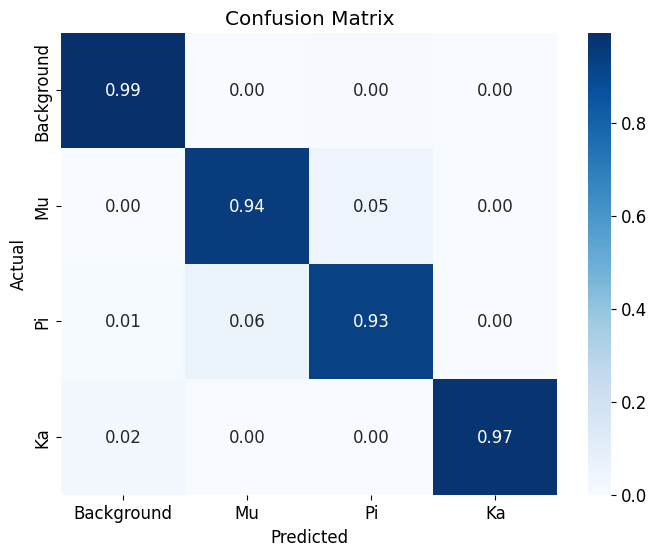

In [40]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
X_test[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [42]:
edf, bdf, gdf, main_angles_tmp = create_edf_decay('decay_test_KMuKPi.root')

(9558, 5)
(9558, 3)


In [57]:
edf

x_c     z_c      y_c       t_c         x_i  \
entry subentry                                                      
0     0        -115.519869  1000.0   -45.92  0.633000 -116.801336   
1     0         109.600131  1000.0   491.68  0.633000  109.342627   
2     0         348.160131  1000.0   508.48  0.645435   77.452963   
      1         348.160131  1000.0   505.12  0.638071   77.452963   
3     0          99.520131  1000.0   488.32  0.663500  114.012507   
...                    ...     ...      ...       ...         ...   
9557  14        -21.439869  1000.0  1167.04  0.681934  -43.032831   
      15          5.440131  1000.0  1187.20  0.771532  -43.032831   
      16         12.160131  1000.0  1193.92  0.781055  -43.032831   
      17          2.080131  1000.0  1187.20  0.768810  -43.032831   
      18        -11.359869  1000.0  1173.76  0.716894  -43.032831   

                        y_i    mass      true_p      beta  x_p  y_p  z_p  \
entry subentry                                                             
0     0          -45.765738  493.68  754.237978  0.836703  0.0  0.0  0.0   
1     0          494.609080  139.57  284.533490  0.897805  0.0  0.0  0.0   
2     0         -968.471110  493.68  852.305574  0.865321  0.0  0.0  0.0   
      1         -968.471110  493.68  852.305574  0.865321  0.0  0.0  0.0   
3     0          499.266831  105.65  369.318512  0.961434  0.0  0.0  0.0   
...                     ...     ...         ...       ...  ...  ...  ...   
9557  14        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      15        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      16        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      17        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      18        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   

                    nx_p      ny_p      nz_p  
entry subentry                                
0     0        -0.115893 -0.045410  0.992223  
1     0         0.097542  0.441230  0.892077  
2     0         0.055552 -0.694618  0.717231  
      1         0.055552 -0.694618  0.717231  
3     0         0.101479  0.444383  0.890071  
...                  ...       ...       ...  
9557  14       -0.026968  0.778813  0.626676  
      15       -0.026968  0.778813  0.626676  
      16       -0.026968  0.778813  0.626676  
      17       -0.026968  0.778813  0.626676  
      18       -0.026968  0.778813  0.626676  

[185151 rows x 15 columns]

In [75]:
np.random.permutation(gdf.index.shape[0]).shape[0]

9558

In [43]:
batch_size=10000

In [44]:
for dcr in  ['1e5'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.array(sorted(np.random.permutation(gdf.index.shape[0])))
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    print(max_iter)
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf.loc[sample_ind]
        gdf_d = gdf.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        # sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        # edf_slice = edf_d.loc[(sample_ind_2)]
        # edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
        # 
        edf_to_bdf(edf_d.mass, bdf)
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        
        print(np.unique(bdf.mass, return_counts=True))
        edf_to_bdf(edf_d.true_p, bdf)
        bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf)
        recoAngles(edf_d, idf, for_decay=True)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True, for_decay=True)
        
        calculateSignalCounts(edf_d, bdf)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf = c_bdf_d

1e5
1
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 139.57, 493.68], dtype=float32), array([3568, 1211, 4779], dtype=int64))
    Time elapsed on current sample:  29
Time elapsed on current DCR:  29


In [41]:
# bdf = bdf[bdf.beta>0.98]

In [79]:
bdf['mass'].fillna(0, inplace=True)
bdf[bdf.mass > 490].mass = ka_mass

In [68]:
bdf = bdf[~bdf.mass.isna()]

In [89]:
np.unique(bdf.mass, return_counts=True)

(array([105.65, 139.57, 493.68], dtype=float32),
 array([3568, 1211, 4779], dtype=int64))

In [88]:
bdf

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance
0,493.679993,754.237976,0.836703,1,8.0,0.124795,0.992223,66.034126,0.972353,0.135649,16.212376,3.698648
1,139.570007,284.533478,0.897805,1,9.0,0.468875,0.892077,29.739145,0.967876,0.070071,7.804653,3.726861
2,493.679993,852.305603,0.865321,0,9.0,0.770976,0.717231,21.035341,0.975124,0.109803,12.689322,5.235826
3,105.650002,369.318512,0.961434,7,10.0,0.473296,0.890071,22.557066,0.967674,0.006240,0.648988,10.345725
4,493.679993,768.594788,0.841386,0,8.0,0.387151,0.925988,23.274046,0.966143,0.124757,14.827594,5.235826
...,...,...,...,...,...,...,...,...,...,...,...,...
9553,105.650002,547.405945,0.981880,30,10.0,0.413319,0.915793,44.435650,0.981792,-0.000088,-0.008990,20.305540
9554,493.679993,727.354126,0.827413,0,8.0,0.344697,0.941178,26.744026,0.966376,0.138963,16.794891,3.726861
9555,105.650002,580.474426,0.983837,33,10.0,0.151214,0.988589,42.648880,0.984539,0.000701,0.071277,21.821320
9556,493.679993,556.572876,0.748111,0,7.0,0.720011,0.751798,29.835943,0.967224,0.219113,29.288912,5.185127


In [45]:
np.sum([round(bdf.loc[i].mass) == round(ka_mass) for i in range(0, len(good_events), 2)])

4779

In [46]:
bdf[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])

In [47]:
bdf['mass_reco'] = label_encoder.inverse_transform(model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))

In [48]:
pi_rel_eff = bdf[(bdf.mass_reco  == pi_mass) & (bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] / (bdf[(bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] + 1e-4)

In [49]:
bkg_rel_eff = bdf[(bdf.mass_reco  == 0) & ((bdf.mass == 0) | (bdf.mass == ka_mass)) & (bdf.theta_p < 0.79)].shape[0] / bdf[((bdf.mass == 0) | (bdf.mass == ka_mass)) & (bdf.theta_p < 0.79)].shape[0]

In [50]:
mu_rel_eff = bdf[(bdf.mass_reco  == mu_mass) & (bdf.mass == mu_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 500)].shape[0] / bdf[(bdf.mass == mu_mass) & (bdf.theta_p < 0.79)& (bdf.momentum > 500)].shape[0]

In [51]:
mu_rel_eff

0.9960629921259843

In [52]:
print(bkg_rel_eff, mu_rel_eff)

0.9679458239277653 0.9960629921259843


In [53]:
print(bkg_rel_eff, mu_rel_eff)

0.9679458239277653 0.9960629921259843


In [54]:
print(pi_rel_eff, mu_rel_eff)

0.5955356611128874 0.9960629921259843


In [55]:
kamu_gen = 0
kapi_gen = 0
kamu_reco = 0
kamu_misreco = 0
for i in range(bdf.shape[0]):
    if bdf.loc[i].theta_p < 0.79 and bdf.loc[i + 1].theta_p < 0.79:
        if round(bdf.loc[i + 1].mass) == round(mu_mass):
            kamu_gen += 1
            if bdf.loc[i].mass_reco == 0 and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_reco += 1
        elif round(bdf.loc[i + 1].mass) == round(pi_mass):
            kapi_gen += 1
            if bdf.loc[i].mass_reco == 0 and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_misreco += 1
        # elif bdf.loc[i].mass_reco == ka_mass and bdf.loc[i + 1].mass_reco == mu_mass:
print('Efficiency', kamu_reco / kamu_gen)
print('MisId', kamu_misreco / kapi_gen)

Efficiency 0.9104674127715603
MisId 0.17403846153846153


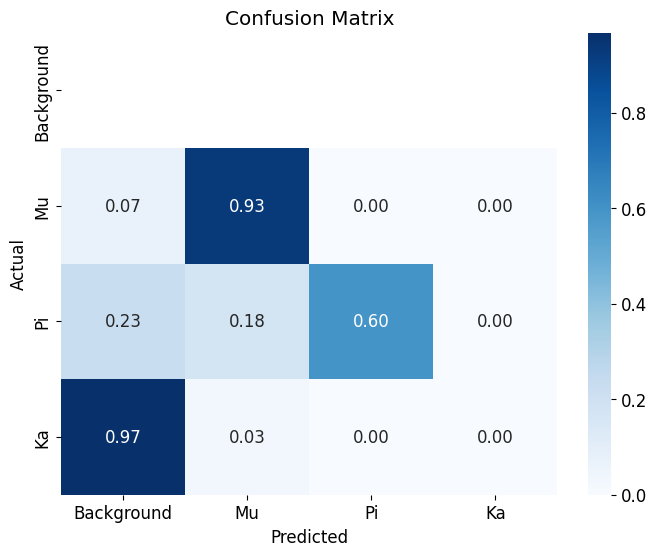

In [56]:
y_test_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass)
# y_pred_2 = model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
y_pred_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass_reco)
cm = confusion_matrix(y_test_2, y_pred_2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

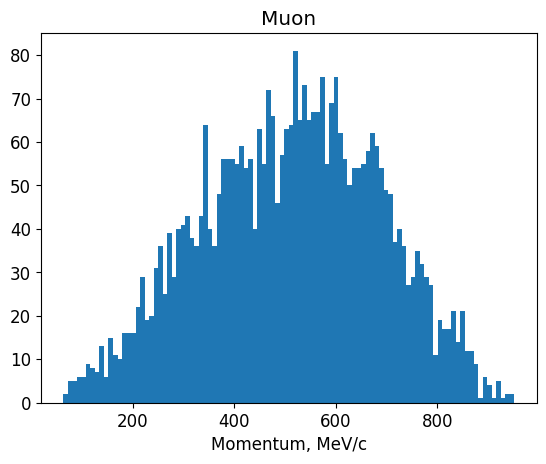

In [83]:
plt.hist(bdf[(bdf.mass == mu_mass)].momentum, bins=100)
plt.title('Muon')
plt.xlabel('Momentum, MeV/c')
plt.show()

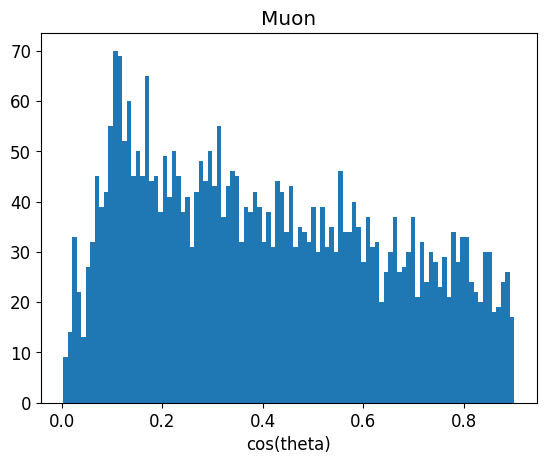

In [110]:
plt.hist(bdf[(bdf.mass == mu_mass)].theta_p, bins=100)
plt.title('Muon')
plt.xlabel('cos(theta)')
plt.show()

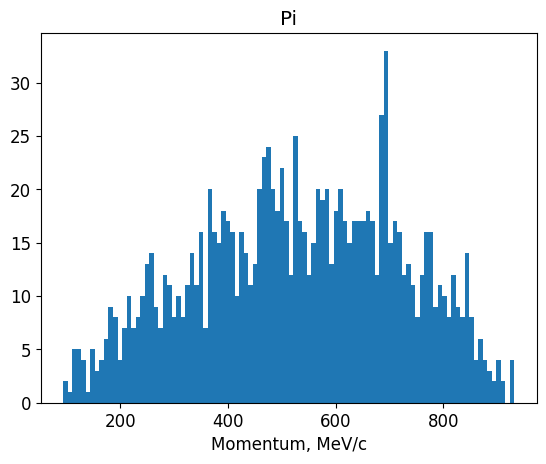

In [84]:
plt.hist(bdf[(bdf.mass == pi_mass)].momentum, bins=100)
plt.title('Pi')
plt.xlabel('Momentum, MeV/c')
plt.show()

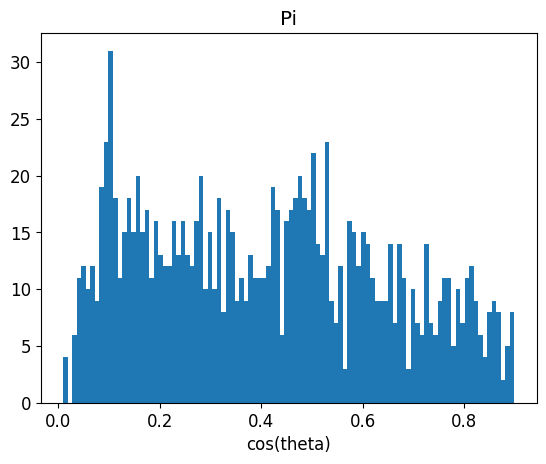

In [109]:
plt.hist(bdf[(bdf.mass == pi_mass)].theta_p, bins=100)
plt.title('Pi')
plt.xlabel('cos(theta)')
plt.show()

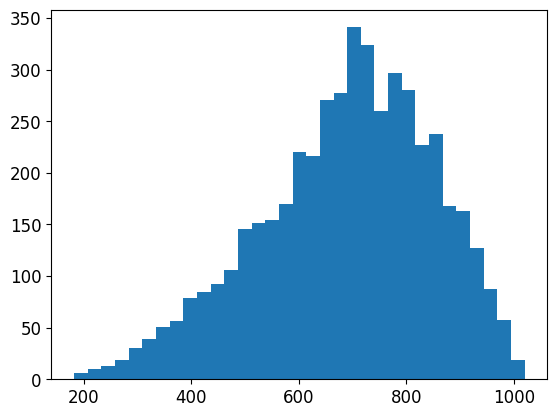

In [72]:
plt.hist(bdf[(bdf.mass == ka_mass)].momentum, bins='auto')
plt.show()

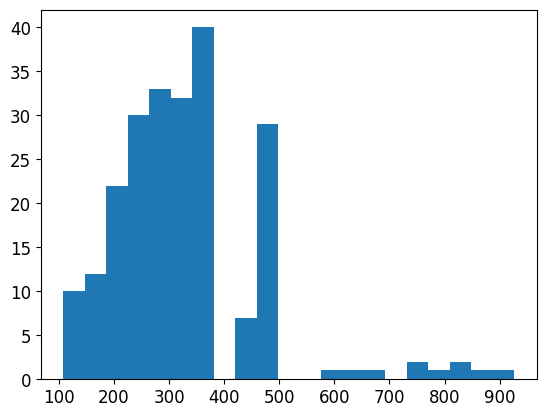

In [59]:
plt.hist(bdf[(bdf.mass == pi_mass) & (bdf.mass_reco == mu_mass)].momentum, bins='auto')
plt.show()

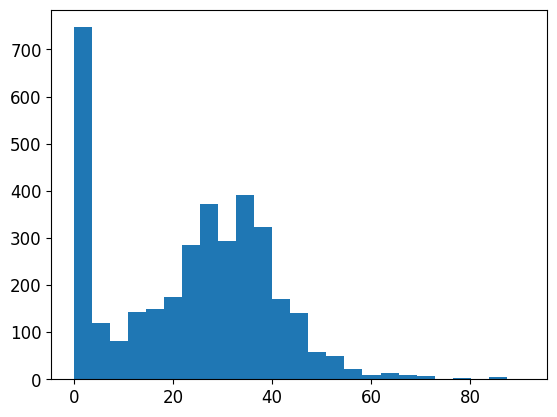

In [65]:
plt.hist(bdf[(bdf.mass == mu_mass)].signal_counts, bins='auto')
plt.show()

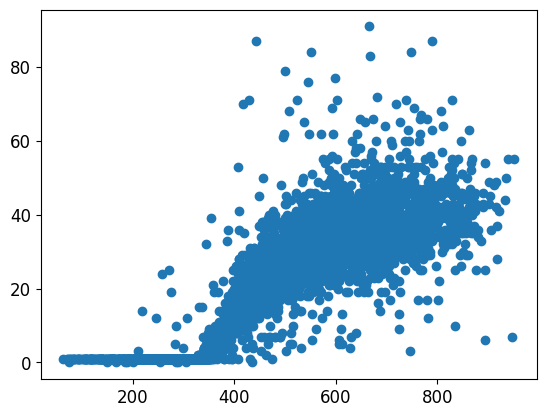

In [73]:
plt.scatter(bdf[bdf.mass == mu_mass].momentum, bdf[bdf.mass == mu_mass].signal_counts)
plt.show()

In [75]:
bdf[(bdf.mass == mu_mass) & (bdf.mass_reco == mu_mass) & (bdf.signal_counts > 1)].shape[0] / bdf[(bdf.mass == mu_mass) & (bdf.signal_counts > 1)].shape[0]

0.9920387677397023

In [69]:
bdf[(bdf.mass == pi_mass) & (bdf.mass_reco == mu_mass) & (bdf.signal_counts > 1)].shape[0] / bdf[(bdf.mass == pi_mass) & (bdf.signal_counts > 1)].shape[0]

0.06337135614702155

спектры всех частиц из своих каналов, пи0 и гамма тоже, и углы
посчитать испульс в поле 1 тесла чтобы попал под углом 45
кусок про откуда координаты и время переписать


In [147]:
800 / (2 * np.sin(np.pi / 8))

1045.2503719011013

In [148]:
1.045 / 3.3

0.31666666666666665

In [90]:
ka_from_mu = []
ka_from_pi = []
for i in range(0, bdf.shape[0], 2):
    if round(bdf.loc[i+1].mass) == round(mu_mass):
        ka_from_mu.append(i)
    elif round(bdf.loc[i+1].mass) == round(pi_mass):
        ka_from_pi.append(i)

In [95]:
bdf.loc[ka_from_mu]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,bckg_proba,mu_proba,pi_proba,ka_proba,mass_reco
2,493.679993,852.305603,0.865321,0,9.0,0.770976,0.717231,30.630986,0.967734,0.102413,11.835266,5.953923,0.998789,0.000003,0.001203,0.000006,0.0
4,493.679993,768.594788,0.841386,0,8.0,0.387151,0.925988,20.556289,0.969761,0.128375,15.257592,7.772325,0.986411,0.000082,0.013473,0.000034,0.0
6,493.679993,720.657532,0.824988,0,8.0,0.413711,0.915635,26.896685,0.966375,0.141387,17.138062,6.747280,0.999093,0.000014,0.000889,0.000004,0.0
12,493.679993,943.804626,0.886099,1,9.0,0.427525,0.909995,45.823519,0.983159,0.097060,10.953650,7.148423,0.979778,0.000012,0.020185,0.000024,0.0
14,493.679993,593.852966,0.768983,0,7.0,0.115821,0.993300,23.712441,0.965896,0.196913,25.606867,6.747280,0.995446,0.000017,0.004531,0.000006,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9548,493.679993,912.090149,0.879441,0,9.0,0.096998,0.995299,30.027940,0.971745,0.092304,10.495739,5.321678,0.999893,0.000012,0.000094,0.000001,0.0
9550,493.679993,544.677246,0.740942,1,7.0,0.629928,0.808070,14.252245,0.973839,0.232897,31.432507,9.147904,0.990721,0.000579,0.008684,0.000017,0.0
9552,493.679993,839.401489,0.861973,0,8.0,0.863243,0.649976,18.536404,0.964351,0.102379,11.877253,9.147904,0.987713,0.000022,0.012245,0.000020,0.0
9554,493.679993,727.354126,0.827413,0,8.0,0.344697,0.941178,62.450278,0.976234,0.148821,17.986254,5.278973,0.998943,0.000174,0.000863,0.000020,0.0


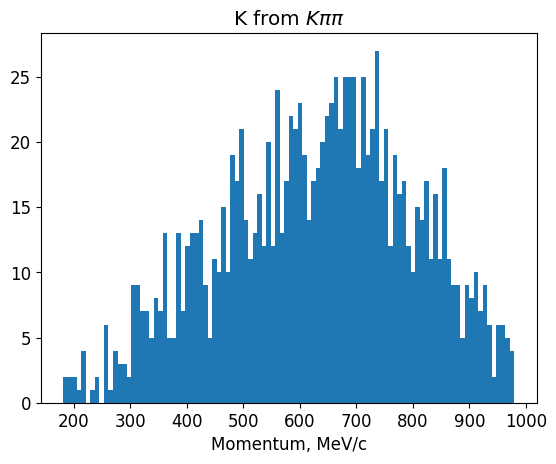

In [107]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_pi].momentum, bins=100)
plt.title(r'K from $K\pi\pi$')
plt.xlabel('Momentum, MeV/c')
plt.show()

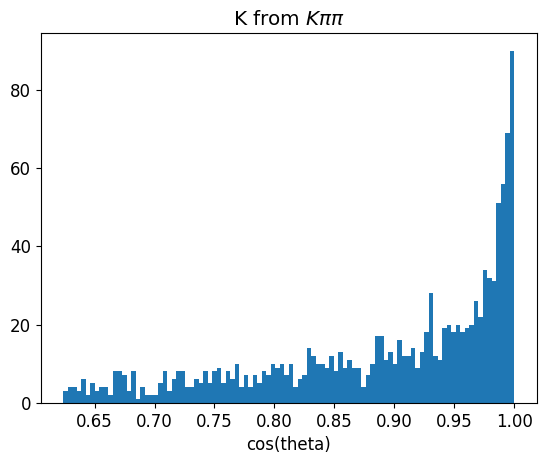

In [112]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_pi].cos_theta_p, bins=100)
plt.title(r'K from $K\pi\pi$')
plt.xlabel('cos(theta)')
plt.show()

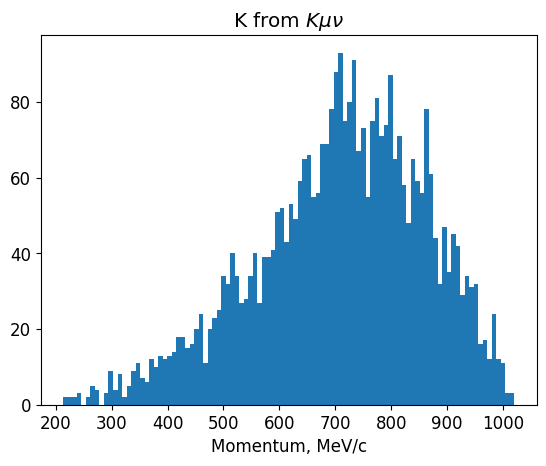

In [103]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_mu].momentum, bins=100)
plt.title(r'K from $K\mu\nu$')
plt.xlabel('Momentum, MeV/c')
plt.show()

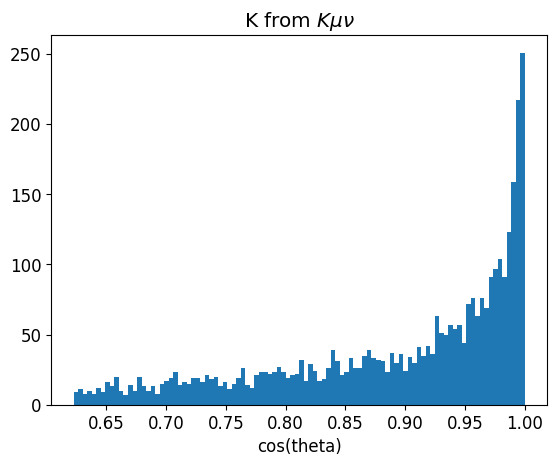

In [116]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_mu].cos_theta_p, bins=100)
plt.title(r'K from $K\mu\nu$')
plt.xlabel('cos(theta)')
plt.show()